<a href="https://colab.research.google.com/github/andrehochuli/teaching/blob/main/ComputerVision/Lecture%2010%20-CNN%20Applications%20and%20Tricks/Lecture_10_CNN_Applications_and_Tricks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning & Convolutional Neural Networks



In [ ]:
import numpy as np
import cv2, glob
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import datasets, layers, models, losses
from tensorflow.keras.models import Model
from sklearn import metrics

#To ensure reproducibility
#we set the random seed
seed_number = 10
tf.random.set_seed(seed_number)
np.random.seed(seed_number)


In [ ]:
#Auxiliary Function to plot images side by side
def plot_sidebyside(img_list,titles,colormap=None,figsize=(12,6)):
  n = len(img_list)
  figure, axis = plt.subplots(1, n, figsize=figsize)
    
  for i in range(n):         
    axis[i].imshow(img_list[i], cmap=colormap)
    axis[i].set_title(titles[i])
    axis[i].axis('off')
  # Combine all the operations and display
  plt.show()

#Plot dataset samples
def plot_dataset(ds, lbls_name):
  N_SAMPLES = 10
  for i in range(5):
    for x,y in ds.take(1):    
      
      x = x.numpy()
      x = np.squeeze(x)      
      y = y.numpy()
      plot_sidebyside(x[:N_SAMPLES],
                      y[:N_SAMPLES],'gray')

#Plot a training history
def plot_history(history):
  print(history.history.keys())
  # summarize history for accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()


# Datasets

In [ ]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
!wget $dataset_url -O flowers.tgz


In [ ]:
!tar -xzf flower_photos.tgz
data_dir = 'flower_photos/'
!ls $data_dir

image_count = len(list(glob.glob(data_dir + '*/*.jpg')))
print(f'The dataset has {image_count} images')

In [ ]:
batch_size_ = 32
input_shape_ = (96,96,3)

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=seed_number,
  image_size=(input_shape_[0], input_shape_[1]),
  batch_size=batch_size_)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=seed_number,  
  image_size=(input_shape_[0], input_shape_[1]),
  batch_size=batch_size_)

In [ ]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)
class_names = np.array(class_names)
for img,lbl in train_ds.take(5):
  
  titles = []
  for i in lbl:    
    titles.append(class_names[lbl[i]])

  plot_sidebyside(img[:5]/255.,titles[:5])

#The Convolutional Layers
  As stated in the last class, a cnn model enqueue several convolutional layers. This step is called 'feature extraction'. In the end of this structure, the resulting matrix is a feature map with dense representations

  Lets see how to code it!

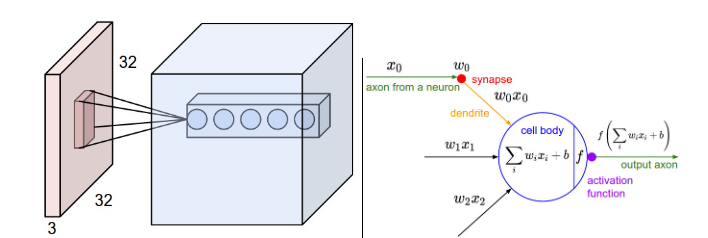


Additional Reference: https://cs231n.github.io/convolutional-networks/

To better illustrate, lets visualize a 65-layer CNN

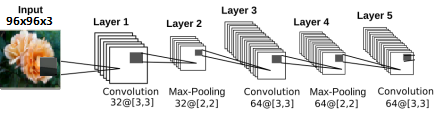

The respective implementation follows:




In [ ]:
model = models.Sequential()

#32 layers of size 3x3 and Relu Activation
model.add(layers.Rescaling(1./255,input_shape=input_shape_))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
#Max Pooling of Size (2x2)
model.add(layers.MaxPooling2D((2, 2)))


#64 layers of size 3x3 and Relu Activation
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#Max Pooling of Size (2x2)
model.add(layers.MaxPooling2D((2, 2)))

#64 layers of size 3x3 and Relu Activation
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.summary()

#The Fully Connected Layer
  The fully connected layer (FC) is a dense layer that receives a 1D tensor. It will provide predictions and probabilities. This is the classification step in the pipeline and can be replaced for another model. (SVM, etc.)

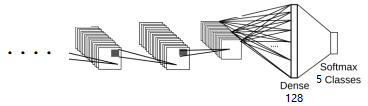

The last layer is a softmax activation

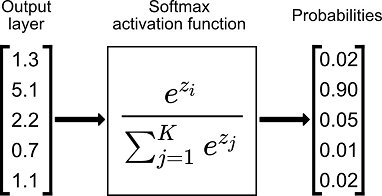

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes,activation='softmax'))

model.summary()

#Training

In [ ]:
epochs_ = 20
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
history = model.fit(train_ds, batch_size=batch_size_, epochs=epochs_, validation_data=val_ds)

#Overfitting
   The model overfitting occurs when the validation accuracy stops increasing when compared to training accuracy. It indicates that the model learns specific noisy or wrong features from the training set. 
   
   The overfitting occurs due to a vanishing gradient, a small number of training examples, or imbalanced data

In [ ]:
plot_history(history)

##Data Augmentation



In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(input_shape_[0],
                                  input_shape_[1],
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [ ]:
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

##Dropout (Regularization)

Dropout regularization removes a random selection of a fixed number of the units in a network layer for a single gradient step. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer

In [ ]:
model = tf.keras.Sequential([
  data_augmentation, #Data Augmentation  
  layers.Rescaling(1./255, input_shape=(96, 96, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),  
  layers.Dropout(0.2), #Regularization
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(5, activation='softmax')
])

In [ ]:
epochs_ = 20
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
history = model.fit(train_ds, batch_size=batch_size_, epochs=epochs_, validation_data=val_ds)

In [ ]:
plot_history(history)

#Transfer Learning

The reasoning behind transfer learning for image classification is that a model trained on a huge dataset could transfer this learning to fit small datasets.  So, you can take advantage of learned features without having to start from scratch on your own data.

To this end, we will used the TensorFlow applications that facilitates the implementation of resnet and transfer learning

Let's say that we want to train the Resnet_50 model to the flowers dataset. 

First, we will train it from scratch. Observe that we have no pre-trained weights and all layers will be tunned.



In [ ]:
#Define resnet archictecture without FC (top) and without pre-trained weights
conv_layers =  tf.keras.applications.resnet50.ResNet50(weights=None, include_top=False,
                                                        input_tensor=tf.keras.layers.Input(input_shape_),
                                                      classes=num_classes)
#Conv Layers will be tunned
conv_layers.trainable = True

model = tf.keras.Sequential([  
  conv_layers,    
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(5, activation='softmax')
])

model.summary()

epochs_ = 20
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
history = model.fit(train_ds, batch_size=batch_size_, epochs=epochs_, validation_data=val_ds)

Now we use the imagenet weights and freeze the conv_layers. It means that conv_layers will be used to feature extraction while dense layers (FC) will be fine-tunned to own data (flowers)

In [ ]:
conv_layers =  tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False,
                                                        input_tensor=tf.keras.layers.Input(input_shape_),
                                                      classes=num_classes)
conv_layers.trainable = False

model = tf.keras.Sequential([  
  conv_layers,    
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(5, activation='softmax')
])

model.summary()

epochs_ = 20
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
history = model.fit(train_ds, batch_size=batch_size_, epochs=epochs_, validation_data=val_ds)